# Comparación de Algoritmos Genéticos (Paso a Paso)

Este notebook está diseñado para explicar en un video, paso a paso, cómo se implementa y se compara un algoritmo genético (AG) original contra una versión mejorada para el Alineamiento Múltiple de Secuencias (MSA).

## Paso 1: Importar Librerías y Configuración Inicial

Primero, importamos todas las librerías necesarias. Usaremos:
- `random`, `copy`, `time` para operaciones básicas.
- `blosum` para cargar la matriz de puntuación BLOSUM62.
- `matplotlib` y `numpy` para promediar resultados y graficar la comparación.

In [1]:
import random
import copy
import time
import blosum
import matplotlib.pyplot as plt
import numpy as np

# Configurar matplotlib para mostrar gráficos en el notebook
%matplotlib inline

# Cargar la matriz BLOSUM62
try:
    blosum62 = blosum.BLOSUM(62)
except Exception as e:
    print(f"Error cargando BLOSUM62: {e}")
    print("Asegúrate de tener la librería 'blosum' instalada: pip install blosum")

# Variable global para contar las evaluaciones de fitness (se resetea en cada 'run')
NFE = 0

## Paso 2: Funciones Comunes (Base del AG)

Estas son las funciones "auxiliares" que ambos algoritmos (Original y Mejorado) utilizarán. Definen la estructura del problema:
- `get_sequences`: Carga las 3 secuencias que queremos alinear.
- `crear_poblacion_inicial`: Crea la población de N individuos.
- `mutar_poblacion_v2`: **Importante:** Esta es la mutación *inicial* que solo se usa una vez para crear diversidad al inicio. No es la mutación generacional.
- `igualar_longitud_secuencias`: Añade gaps ('-') al final para que todas las secuencias en un individuo midan lo mismo.
- `evaluar_individuo_blosum62`: La **Función de Fitness**. Calcula el score Sum-of-Pairs usando BLOSUM62 y una penalización de -4 por gap.
- `eliminar_peores`: El operador de **Selección**. Ordena los individuos por fitness y se queda con el 50% mejor.
- `validar_poblacion_sin_gaps`: La **Validación de Integridad**. Revisa que los aminoácidos (sin gaps) sigan siendo los mismos que los originales.
- `obtener_best`: Simplemente reporta el mejor individuo de la generación actual.

In [2]:
def get_sequences():
    seq1 = "MGSSHHHHHHSSGLVPRGSHMASMTGGQQMGRDLYDDDDKDRWGKLVVLGAVTQGQKLVVLGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQV"
    seq2 = "MKTLLVAAAVVAGGQGQAEKLVKQLEQKAKELQKQLEQKAKELQKQLEQKAKELQKQLEQKAKELQKQLEQKAGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQKELQKQLGQKAKEL"
    seq3 = "MAVTQGQKLVVLGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFAVVAGGQGQAEKLVKQLEQKAKELQKQLEQKAKELQKQLEQKAKELQKQLEQKAKELQKQLEQKALCVFAIN"
    return [list(seq1), list(seq2), list(seq3)]

def crear_individuo():
    return get_sequences()

def crear_poblacion_inicial(n=10):
    individuo_base = crear_individuo()
    poblacion = [ [row[:] for row in individuo_base] for _ in range(n) ]
    return poblacion

def mutar_poblacion_v2(poblacion, num_gaps=1):
    """Mutación inicial para crear diversidad."""
    poblacion_mutada = []
    for individuo in poblacion:
        nuevo_individuo = []
        for fila in individuo:
            fila_mutada = fila[:]
            posiciones = set()
            for _ in range(num_gaps):
                pos = random.randint(0, len(fila_mutada))
                while pos in posiciones:
                    pos = random.randint(0, len(fila_mutada))
                posiciones.add(pos)
                fila_mutada.insert(pos, '-')
            nuevo_individuo.append(fila_mutada)
        poblacion_mutada.append(nuevo_individuo)
    return poblacion_mutada

def igualar_longitud_secuencias(individuo, gap='-'):
    max_len = max(len(fila) for fila in individuo)
    individuo_igualado = [fila + [gap]*(max_len - len(fila)) for fila in individuo]
    return individuo_igualado


def evaluar_individuo_blosum62(individuo):
    global NFE
    NFE += 1
    score = 0
    n_seqs = len(individuo)
    seq_len = len(individuo[0])
    for col in range(seq_len):
        for i in range(n_seqs):
            for j in range(i+1, n_seqs):
                a = individuo[i][col]
                b = individuo[j][col]
                if a == '-' or b == '-':
                    score -= 4
                else:
                    if a in blosum62 and b in blosum62[a]:
                        score += blosum62[a][b]
                    elif b in blosum62 and a in blosum62[b]:
                        score += blosum62[b][a]
                    else:
                        score -= 4 
    return score

def eliminar_peores(poblacion, scores, porcentaje=0.5):
    idx_ordenados = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    n_seleccionados = int(len(poblacion) * porcentaje)
    ind_seleccionados = [poblacion[i] for i in idx_ordenados[:n_seleccionados]]
    scores_seleccionados = [scores[i] for i in idx_ordenados[:n_seleccionados]]
    return ind_seleccionados, scores_seleccionados

def validar_poblacion_sin_gaps(poblacion, originales):
    for individuo in poblacion:
        for seq, seq_orig in zip(individuo, originales):
            seq_sin_gaps = [a for a in seq if a != '-']
            seq_orig_sin_gaps = [a for a in seq_orig if a != '-']
            if seq_sin_gaps != seq_orig_sin_gaps:
                print("¡Validación de integridad fallida!")
                print("Original:", "".join(seq_orig_sin_gaps))
                print("Obtenida:", "".join(seq_sin_gaps))
                return False
    return True

def obtener_best(scores, poblacion):
    idx_mejor = scores.index(max(scores))
    fitness_best = scores[idx_mejor]
    best = copy.deepcopy(poblacion[idx_mejor])
    return best, fitness_best

## Paso 3: Implementación del Algoritmo Original

Aquí definimos los operadores genéticos de la versión *Original*.

La parte clave es la función `cruzar_individuos_doble_punto_original`:
1.  Realiza la cruza.
2.  Aplica una **mutación de inserción de gap con probabilidad altísima (p=0.8)**.

Esta probabilidad tan alta es caótica: destruye la mayoría de las buenas soluciones que la cruza encuentra. Es un operador de **exploración** muy agresivo y poco eficiente.

In [3]:
def mutar_individuo_original(individuo, n_gaps, p):
    """Mutación original: solo inserta gaps aleatorios."""
    nuevo_individuo = []
    for secuencia in individuo:
        sec = secuencia[:]
        if random.random() < p:
            posiciones = set()
            for _ in range(n_gaps):
                pos = random.randint(0, len(sec))
                while pos in posiciones:
                    pos = random.randint(0, len(sec))
                posiciones.add(pos)
                sec.insert(pos, '-')
        nuevo_individuo.append(sec)
    return nuevo_individuo

def cruzar_individuos_doble_punto_original(ind1, ind2):
    hijo1 = []
    hijo2 = []
    for seq1, seq2 in zip(ind1, ind2):
        aa_indices = [i for i, a in enumerate(seq1) if a != '-']
        if len(aa_indices) < 6:
            hijo1.append(seq1[:])
            hijo2.append(seq2[:])
            continue

        intentos = 0
        while True:
            if len(aa_indices) < 2:
                p1, p2 = 0, len(aa_indices) -1
                if p1 < 0: break
            else:
                 p1, p2 = sorted(random.sample(aa_indices, 2))

            if p2 - p1 >= 5 or intentos > 10 or (p1==0 and p2==-1):
                break
            intentos += 1
        
        if p1 < 0:
            hijo1.append(seq1[:])
            hijo2.append(seq2[:])
            continue

        def cruza(seqA, seqB):
            aaA = [a for a in seqA if a != '-']
            aaB = [a for a in seqB if a != '-']
            len_aaA = len(aaA)
            len_aaB = len(aaB)
            p1_c = min(p1, len_aaA, len_aaB)
            p2_c = min(p2, len_aaA, len_aaB)
            nueva = aaA[:p1_c] + aaB[p1_c:p2_c] + aaA[p2_c:]
            resultado = []
            idx = 0
            for a in seqA:
                if a == '-':
                    resultado.append('-')
                else:
                    if idx < len(nueva):
                        resultado.append(nueva[idx])
                        idx += 1
                    else:
                        resultado.append('-')
            return resultado

        nueva_seq1 = cruza(seq1, seq2)
        nueva_seq2 = cruza(seq2, seq1)
        hijo1.append(nueva_seq1)
        hijo2.append(nueva_seq2)

    # --- ESTRATEGIA ORIGINAL (CAÓTICA) ---
    hijo1 = mutar_individuo_original(hijo1, 1, 0.8) # 80% de probabilidad!
    hijo2 = mutar_individuo_original(hijo2, 1, 0.8)
    return hijo1, hijo2

def cruzar_poblacion_doble_punto_original(poblacion):
    nueva_poblacion = []
    n = len(poblacion)
    indices = list(range(n))
    random.shuffle(indices)
    parejas = [(indices[i], indices[i+1]) for i in range(0, n-1, 2)]
    if n % 2 == 1:
        parejas.append((indices[-1], indices[0]))
    for idx1, idx2 in parejas:
        padre1 = poblacion[idx1]
        padre2 = poblacion[idx2]
        hijo1, hijo2 = cruzar_individuos_doble_punto_original(padre1, padre2)
        nueva_poblacion.append(copy.deepcopy(padre1))
        nueva_poblacion.append(copy.deepcopy(padre2))
        nueva_poblacion.append(hijo1)
        nueva_poblacion.append(hijo2)
    return nueva_poblacion[:2*n]

def run_original_ag(generaciones, tam_poblacion, verbose=False):
    """Ejecuta una corrida completa del AG Original."""
    global NFE
    NFE = 0
    start_time = time.time()
    
    veryBest = None
    fitnessVeryBest = -float('inf')
    historial_fitness = []
    secuencias_originales = get_sequences()

    poblacion = crear_poblacion_inicial(tam_poblacion)
    poblacion = mutar_poblacion_v2(poblacion, num_gaps=1)
    poblacion = [igualar_longitud_secuencias(ind) for ind in poblacion]
    scores = [evaluar_individuo_blosum62(ind) for ind in poblacion]
    poblacion, scores = eliminar_peores(poblacion, scores)
    
    for gen in range(generaciones):
        poblacion = cruzar_poblacion_doble_punto_original(poblacion)
        poblacion = [igualar_longitud_secuencias(ind) for ind in poblacion]
        scores = [evaluar_individuo_blosum62(ind) for ind in poblacion]
        poblacion, scores = eliminar_peores(poblacion, scores)
        
        if not scores:
            if verbose: print(f"Gen {gen}: Población eliminada, deteniendo.")
            break

        best, fitness_best = obtener_best(scores, poblacion)
        
        if fitness_best > fitnessVeryBest:
            veryBest = best
            fitnessVeryBest = fitness_best
            
        historial_fitness.append(fitnessVeryBest)
        
        if verbose and (gen % 10 == 0 or gen == generaciones - 1):
            transcurrido = time.time() - start_time
            print(f"[Orig] Gen: {gen:03d}, Fitness: {fitnessVeryBest:8.0f}, NFE: {NFE:05d}, Time: {transcurrido:06.2f}s")

    if not validar_poblacion_sin_gaps(poblacion, secuencias_originales):
        print("ERROR: ¡Validación de integridad fallida en AG Original!")
        
    return historial_fitness, fitnessVeryBest

## Paso 4: Implementación del Algoritmo Mejorado

Aquí está la **MEJORA**. Introducimos un nuevo operador de mutación: `mutar_individuo_gap_shift_mejorado`.
- Este operador no inserta gaps, sino que *mueve* un gap existente a la izquierda o derecha.
- Es un operador de **Explotación** (búsqueda local o refinamiento).

La estrategia en `cruzar_individuos_doble_punto_mejorado` se cambia a un **balance**:
1.  **Exploración (p=0.15):** Una probabilidad *baja* (15%) de insertar un gap (usando `mutar_individuo_mejorado`).
2.  **Explotación (p_seq=0.2):** Una probabilidad *baja* (20%) de mover un gap existente (usando `mutar_individuo_gap_shift_mejorado`).

Este balance permite al algoritmo encontrar nuevas soluciones (exploración) sin destruir las buenas, y al mismo tiempo refinarlas (explotación) para alcanzar un mejor fitness.

In [7]:
def mutar_individuo_mejorado(individuo, n_gaps, p):
    """Mutación de exploración (igual a la original): inserta gaps aleatorios."""
    nuevo_individuo = []
    for secuencia in individuo:
        sec = secuencia[:]
        if random.random() < p:
            posiciones = set()
            for _ in range(n_gaps):
                pos = random.randint(0, len(sec))
                while pos in posiciones:
                    pos = random.randint(0, len(sec))
                posiciones.add(pos)
                sec.insert(pos, '-')
        nuevo_individuo.append(sec)
    return nuevo_individuo

def mutar_individuo_gap_shift_mejorado(individuo, p_seq=0.5):
    """MEJORA: Mutación "inteligente" (búsqueda local) que mueve gaps existentes."""
    nuevo_individuo = []
    for secuencia in individuo:
        sec = secuencia[:]
        if random.random() < p_seq:
            gap_indices = [i for i, a in enumerate(sec) if a == '-']
            if not gap_indices:
                nuevo_individuo.append(sec)
                continue

            idx_gap = random.choice(gap_indices)
            direccion = random.randint(0, 1)
            
            if direccion == 0 and idx_gap > 0: # Mover a la izquierda
                sec[idx_gap], sec[idx_gap - 1] = sec[idx_gap - 1], sec[idx_gap]
            elif direccion == 1 and idx_gap < len(sec) - 1: # Mover a la derecha
                sec[idx_gap], sec[idx_gap + 1] = sec[idx_gap + 1], sec[idx_gap]
                
        nuevo_individuo.append(sec)
    return nuevo_individuo

def cruzar_individuos_doble_punto_mejorado(ind1, ind2):
    hijo1 = []
    hijo2 = []
    for seq1, seq2 in zip(ind1, ind2):
        aa_indices = [i for i, a in enumerate(seq1) if a != '-']
        if len(aa_indices) < 6:
            hijo1.append(seq1[:])
            hijo2.append(seq2[:])
            continue

        intentos = 0
        while True:
            if len(aa_indices) < 2:
                p1, p2 = 0, len(aa_indices) -1
                if p1 < 0: break
            else:
                 p1, p2 = sorted(random.sample(aa_indices, 2))

            if p2 - p1 >= 5 or intentos > 10 or (p1==0 and p2==-1):
                break
            intentos += 1
        
        if p1 < 0:
            hijo1.append(seq1[:])
            hijo2.append(seq2[:])
            continue

        def cruza(seqA, seqB):
            aaA = [a for a in seqA if a != '-']
            aaB = [a for a in seqB if a != '-']
            len_aaA = len(aaA)
            len_aaB = len(aaB)
            p1_c = min(p1, len_aaA, len_aaB)
            p2_c = min(p2, len_aaA, len_aaB)
            nueva = aaA[:p1_c] + aaB[p1_c:p2_c] + aaA[p2_c:]
            resultado = []
            idx = 0
            for a in seqA:
                if a == '-':
                    resultado.append('-')
                else:
                    if idx < len(nueva):
                        resultado.append(nueva[idx])
                        idx += 1
                    else:
                        resultado.append('-')
            return resultado

        nueva_seq1 = cruza(seq1, seq2)
        nueva_seq2 = cruza(seq2, seq1)
        hijo1.append(nueva_seq1)
        hijo2.append(nueva_seq2)

    # --- INICIO DE LA MEJORA (ESTRATEGIA BALANCEADA) ---
    
    # 1. Mutación de Exploración (probabilidad baja de añadir un gap)
    hijo1 = mutar_individuo_mejorado(hijo1, 1, p=0.15) # 15% de probabilidad
    hijo2 = mutar_individuo_mejorado(hijo2, 1, p=0.15)
    
    # 2. Mutación de Explotación (probabilidad baja de mover un gap)
    hijo1 = mutar_individuo_gap_shift_mejorado(hijo1, p_seq=0.2) # 20% de probabilidad por secuencia
    hijo2 = mutar_individuo_gap_shift_mejorado(hijo2, p_seq=0.2)
    # --- FIN DE LA MEJORA ---
    
    return hijo1, hijo2

def cruzar_poblacion_doble_punto_mejorado(poblacion):
    nueva_poblacion = []
    n = len(poblacion)
    indices = list(range(n))
    random.shuffle(indices)
    parejas = [(indices[i], indices[i+1]) for i in range(0, n-1, 2)]
    if n % 2 == 1:
        parejas.append((indices[-1], indices[0]))
    for idx1, idx2 in parejas:
        padre1 = poblacion[idx1]
        padre2 = poblacion[idx2]
        hijo1, hijo2 = cruzar_individuos_doble_punto_mejorado(padre1, padre2)
        nueva_poblacion.append(copy.deepcopy(padre1))
        nueva_poblacion.append(copy.deepcopy(padre2))
        nueva_poblacion.append(hijo1)
        nueva_poblacion.append(hijo2)
    return nueva_poblacion[:2*n]

def run_mejorado_ag(generaciones, tam_poblacion, verbose=False):
    """Ejecuta una corrida completa del AG Mejorado."""
    global NFE
    NFE = 0
    start_time = time.time()
    
    veryBest = None
    fitnessVeryBest = -float('inf')
    historial_fitness = []
    secuencias_originales = get_sequences()

    poblacion = crear_poblacion_inicial(tam_poblacion)
    poblacion = mutar_poblacion_v2(poblacion, num_gaps=1)
    poblacion = [igualar_longitud_secuencias(ind) for ind in poblacion]
    scores = [evaluar_individuo_blosum62(ind) for ind in poblacion]
    poblacion, scores = eliminar_peores(poblacion, scores)
    
    for gen in range(generaciones):
        poblacion = cruzar_poblacion_doble_punto_mejorado(poblacion)
        poblacion = [igualar_longitud_secuencias(ind) for ind in poblacion]
        scores = [evaluar_individuo_blosum62(ind) for ind in poblacion]
        poblacion, scores = eliminar_peores(poblacion, scores)
        
        if not scores:
            if verbose: print(f"Gen {gen}: Población eliminada, deteniendo.")
            break

        best, fitness_best = obtener_best(scores, poblacion)
        
        if fitness_best > fitnessVeryBest:
            veryBest = best
            fitnessVeryBest = fitness_best
            
        historial_fitness.append(fitnessVeryBest)
        
        if verbose and (gen % 10 == 0 or gen == generaciones - 1):
            transcurrido = time.time() - start_time
            print(f"[Mejo] Gen: {gen:03d}, Fitness: {fitnessVeryBest:8.0f}, NFE: {NFE:05d}, Time: {transcurrido:06.2f}s")

    if not validar_poblacion_sin_gaps(poblacion, secuencias_originales):
        print("ERROR: ¡Validación de integridad fallida en AG Mejorado!")

    return historial_fitness, fitnessVeryBest

## Paso 5: Ejecución de la Simulación

Ahora, ejecutamos ambos algoritmos. Para obtener un resultado justo (ya que los AGs dependen del azar), los ejecutamos varias veces (`N_RUNS`) y promediamos los resultados.

In [5]:
N_RUNS = 5 # Número de corridas para promediar
GENS = 100 # Número de generaciones por corrida
POB_SIZE = 10 # Tamaño de la población

all_original_histories = []
all_mejorado_histories = []
final_original_scores = []
final_mejorado_scores = []

print(f"Iniciando {N_RUNS} corridas de {GENS} generaciones cada una...")

for i in range(N_RUNS):
    print(f"--- Corrida {i+1}/{N_RUNS} ---")
    
    # Ejecutar Original
    print("Ejecutando AG Original...")
    hist_orig, score_orig = run_original_ag(GENS, POB_SIZE, verbose=True)
    all_original_histories.append(hist_orig)
    final_original_scores.append(score_orig)
    
    # Ejecutar Mejorado
    print("Ejecutando AG Mejorado...")
    hist_mejo, score_mejo = run_mejorado_ag(GENS, POB_SIZE, verbose=True)
    all_mejorado_histories.append(hist_mejo)
    final_mejorado_scores.append(score_mejo)

print("\n--- Simulación Completa ---")

# Calcular promedios
avg_original_fitness = np.mean(final_original_scores)
avg_mejorado_fitness = np.mean(final_mejorado_scores)

print(f"Fitness Promedio Final (Original): {avg_original_fitness:.2f}")
print(f"Fitness Promedio Final (Mejorado): {avg_mejorado_fitness:.2f}")
print(f"Mejora: {avg_mejorado_fitness - avg_original_fitness:.2f} puntos")

# Preparar datos para la gráfica (promedio por generación)
# Rellenar historias más cortas si alguna corrida se detuvo antes
def pad_history(history_list, length):
    padded_list = []
    for hist in history_list:
        if len(hist) < length:
            # Rellenar con el último valor conocido
            padding = [hist[-1]] * (length - len(hist)) if hist else [0] * length
            padded_list.append(hist + padding)
        else:
            padded_list.append(hist[:length])
    return padded_list

padded_original_histories = pad_history(all_original_histories, GENS)
padded_mejorado_histories = pad_history(all_mejorado_histories, GENS)

avg_orig_history = np.mean(np.array(padded_original_histories), axis=0)
avg_mejo_history = np.mean(np.array(padded_mejorado_histories), axis=0)


Iniciando 5 corridas de 100 generaciones cada una...
--- Corrida 1/5 ---
Ejecutando AG Original...
[Orig] Gen: 000, Fitness:     -408, NFE: 00020, Time: 000.01s
[Orig] Gen: 010, Fitness:     -408, NFE: 00120, Time: 000.04s
[Orig] Gen: 020, Fitness:     -408, NFE: 00220, Time: 000.07s
[Orig] Gen: 030, Fitness:     -408, NFE: 00320, Time: 000.11s
[Orig] Gen: 040, Fitness:     -400, NFE: 00420, Time: 000.14s
[Orig] Gen: 050, Fitness:     -400, NFE: 00520, Time: 000.17s
[Orig] Gen: 060, Fitness:     -400, NFE: 00620, Time: 000.20s
[Orig] Gen: 070, Fitness:     -400, NFE: 00720, Time: 000.24s
[Orig] Gen: 080, Fitness:     -400, NFE: 00820, Time: 000.27s
[Orig] Gen: 090, Fitness:     -400, NFE: 00920, Time: 000.30s
[Orig] Gen: 099, Fitness:     -400, NFE: 01010, Time: 000.33s
Ejecutando AG Mejorado...
[Mejo] Gen: 000, Fitness:     -435, NFE: 00020, Time: 000.00s
[Mejo] Gen: 010, Fitness:     -420, NFE: 00120, Time: 000.04s
[Mejo] Gen: 020, Fitness:     -418, NFE: 00220, Time: 000.08s
[Mejo] 

## Paso 6: Generar Gráfica Comparativa

Finalmente, graficamos los resultados. Esta celda toma los historiales de fitness promedio de todas las corridas y los compara en una sola gráfica.

- **Línea Azul (Original):** Debería estancarse en un fitness más bajo, debido a su mutación caótica.
- **Línea Roja (Mejorado):** Debería alcanzar un fitness más alto, gracias a su estrategia balanceada de exploración y explotación.

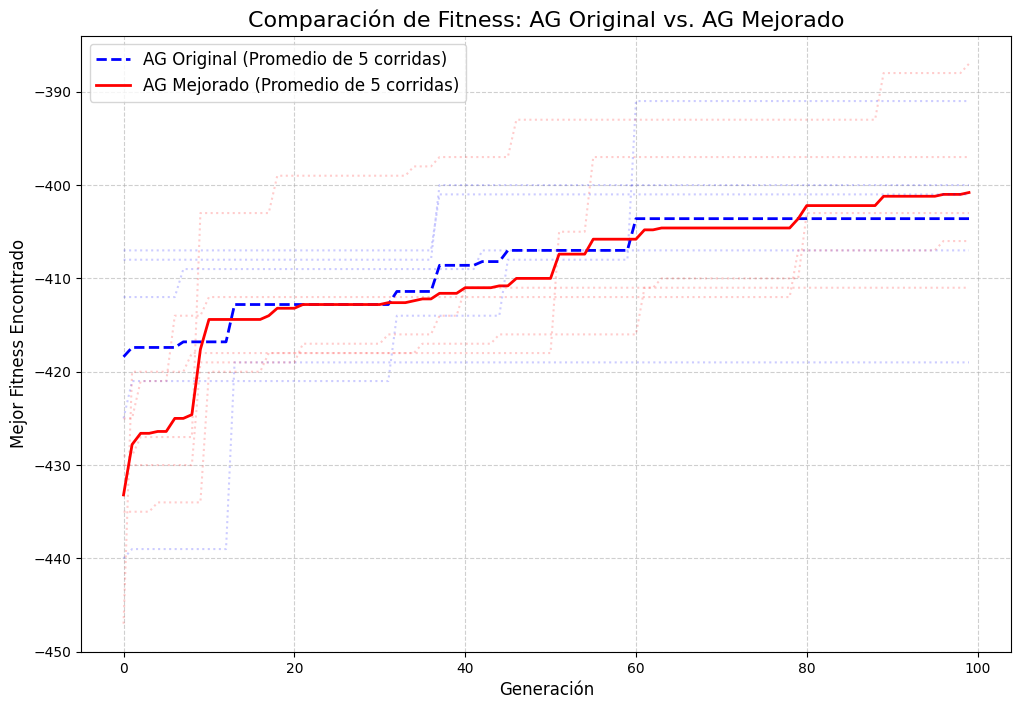

In [8]:
plt.figure(figsize=(12, 8))

# Graficar el promedio de las corridas
plt.plot(avg_orig_history, label=f'AG Original (Promedio de {N_RUNS} corridas)', linewidth=2, color='blue', linestyle='--')
plt.plot(avg_mejo_history, label=f'AG Mejorado (Promedio de {N_RUNS} corridas)', linewidth=2, color='red')

# Opcional: graficar todas las corridas individuales con transparencia
for hist in padded_original_histories:
    plt.plot(hist, color='blue', alpha=0.2, linestyle=':')
for hist in padded_mejorado_histories:
    plt.plot(hist, color='red', alpha=0.2, linestyle=':')

plt.title('Comparación de Fitness: AG Original vs. AG Mejorado', fontsize=16)
plt.xlabel('Generación', fontsize=12)
plt.ylabel('Mejor Fitness Encontrado', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Paso 7: Conclusión

Como se observa en la gráfica, la línea del **Algoritmo Mejorado** (roja) consistentemente alcanza un valor de fitness más alto que la del **Algoritmo Original** (azul).

Esto demuestra la efectividad de la mejora. El algoritmo original usaba una probabilidad de mutación (inserción de gap) altísima (80%), lo que lo convertía en una búsqueda caótica que destruía las buenas soluciones. 

La **mejora** consiste en reemplazar esa única mutación caótica por una estrategia balanceada de dos mutaciones con **baja probabilidad**:

1.  **Exploración** (mutación de inserción de gap, `p=0.15`): Introduce nueva diversidad de forma controlada.
2.  **Explotación** (mutación de "gap shifting", `p_seq=0.2`): Refina las soluciones buenas ya existentes.

Esta combinación permite al algoritmo retener las buenas soluciones (gracias a la baja probabilidad) y, al mismo tiempo, refinarlas (gracias al gap shifting), lo que le permite escalar a picos de fitness más altos.